## The Analytical Approach to Hypothesis Testing

This notebook introduces the analytical approach to hypothesis testing.  It assumes the reader is already familiar with the idea of testing hypotheses using a simulation approach.

### The analytical approach.

A common question that arises in hypothesis testing is whether or not the mean two populations differs (e.g. are first babies born late?).  In ThinkStats, Allen shows how to attack this question from a simulation perspective.  Using the strategy of permuation, one can get a sense for how likely one would observe a difference in means as large or greater than what we observed in the data under the null hypothesis.

Another approach to answering this question is to use an analytical approach.  By analytical I mean that it doesn't rely on simulation to compute the p-value.

One of the most popular ways to test the hypothesis that two populations have different means is to use a t-test.  The t-test uses the following test statistic to assess whether two populations have differing means.

Before we jump into using a t-test to determine whether or not two populations have different means, we will treat the problem of determining whether or not a particular population has a difference in mean greater than 0.

Suppose we observe a sample from some population $x_1, x_2, \ldots, x_n$.  We compute the following test statistic (called the t-statistic).

$$t = \sqrt{n}\left ( \frac{\bar{x}}{s} \right )\mbox{, where}$$

$$\bar{x} = \frac{1}{n} \sum_{i=1}^n x_i \mbox{, is the sample mean and}$$

$$s = \sqrt{\frac{1}{n-1} \sum_{i=1}^n \left (x_i - \bar{x} \right )^2}\mbox{, is the sample standard deviation.}$$

Intuitively, the higher the t-statistic, the *more* confident we are that an observed mean is unlikely to have arisen by chance.  Take a few minutes to reason about the t-statistic.  Does it make sense which factors make it larger and which make it smaller?

Next, we will see the t-test in action.  The following cell uses a p-value using a one-sample t-test.  That is, tries to answer the question "How likely would we be to observe a sample mean as large or greater than what we did under the null hypothesis."

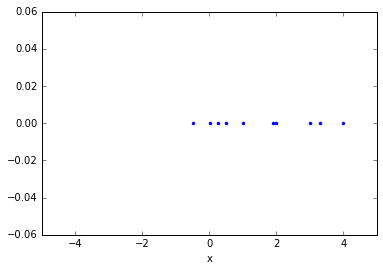

Ttest_1sampResult(statistic=3.0884354283516151, pvalue=0.011474517653278175)

In [224]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ttest_1samp

# this is our dataset
x = [1.0, 2.0, -.5, 3.0, 4.0, .025, .25, .5, 7, 3.3, 1.9]
plt.plot(x, [0]*len(x), 'b.')
plt.xlabel('x')
plt.xlim([-5, 5])
plt.show()
ttest_1samp(x, 0)

Intuitively, what is this test telling us?  To make sure that we have a clear sense of what the statistic reported above is, let's  write our own code to compute the t-statistic.

In [226]:
def get_t_stat(x):
    """ Computes the t-statistic for the specified sample x """
    return len(x)**0.5*np.mean(x) / (np.std(x, ddof=1))

t_stat = get_t_stat(x)
print t_stat

3.08843542835


Cool, cool!  However, we are still left with the mystery of where the heck that p-value came from.  To start, we can understand this p-value using a simulation approach.  In order to simulate our null hypothesis, we make the following two assumptions:
1.  The population has a Gaussian distribution (bell curve).
2.  The mean of the Gaussian is 0 and the standard deviation is equal to the sample standard deviation.

First, we compute the sample standard deviation.  Then, we use the technique of simulation in order to determine how likely a sample of size $len(x)$ from our population would be to have a t-statistic with a magnitude equal to or greater than the one observed in our sample.

In [252]:
n_trials = 100000
s = np.std(x, ddof=1)
p_value = np.mean([abs(get_t_stat(np.random.normal(scale=sigma,
                                                   size=(len(values),)))) > t_stat
                   for i in range(n_trials)])
print "p-value computed via simulation", p_value

p-value computed via simulation 0.01141


Alright!  It looks like we cracked this one.  The p-value as computed by a one sample t-test can be understood in the simulation based framework we learned about in ThinkStats!

This still leaves a fundamental question: Why???  What in the world motivates the particular form of the t-statistic?  The answer has to do with the fact that we don't really need to do simulation at all to compute our p-value!  This is because the distribution of t-statistics under the null hypothesis has a well known an convenient to work with form.

To see this, let's first visualize the distribution of t-statitics computed above.

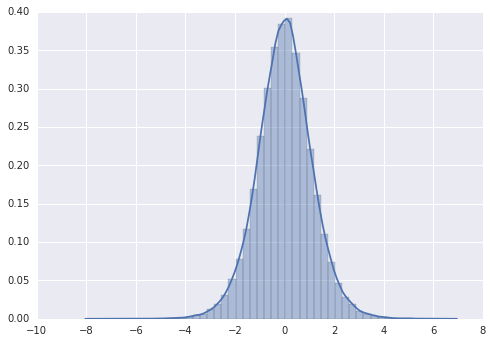

In [253]:
import seaborn as sns

t_stats = [get_t_stat(np.random.normal(scale=sigma,
                                       size=(len(values),))) for i in range(n_trials)]
sns.distplot(t_stats)

It turns out that the distribution shown above is known as a [student's t-distribution](https://en.wikipedia.org/wiki/Student's_t-distribution).  In much the way that the shape of a Gaussian distribution has a shape controlled by two parameters: mean and standard deviation, the t-distribution has a single parameter that controls its shape called $\nu$.  $\nu$ represents the degrees of freedom, and in the case of our one sample t-test above, $\nu = len(x) - 1$.  To verify that our sampling distribution and the student's t-distribution are indeed the same, we will plot them on the same axes.

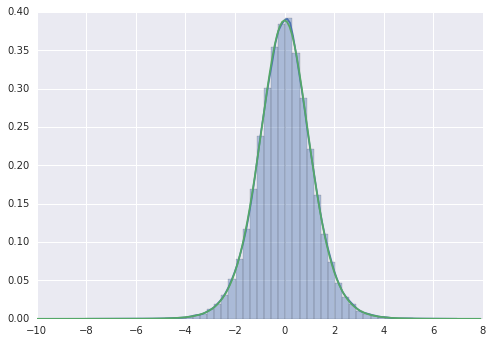

In [255]:
import scipy.stats

sns.distplot(t_stats)
points = np.arange(plt.xlim()[0], plt.xlim()[1], .1)
plt.plot(points, [scipy.stats.t.pdf(point, len(x) - 1) for point in points])
plt.show()

Given that we already know what the sampling distribution of the t-statistic is before doing the simulation it appears that the simulation was not necessary after all!  Given this knowledge, we can use the cdf of the t-distribution to compute our p-value.

In [258]:
1 - scipy.stats.t.cdf(t_stat, len(x) - 1) + scipy.stats.t.cdf(-t_stat, len(x) - 1)

0.011474517653278201

Given what we just learned, why shouldn't we always use a t-test to compute the p-value?

### Testing a Correlation

The t-test can be used to test all sorts of things.  We already alluded to the fact that it can be used to determine whether two samples have differing means.  A major use of the t-test is to determine whether or not a correlation is significant.  Suppose we have a sample where each point consists of two values: x and y.

$$(x_1, y_1), (x_2, y_2), \ldots, (x_n, y_n)$$

First, we compute the coefficient of correlation, $R$, between $x$ and $y$.  We can now define the following t-statistic.

$$t = \sqrt{N-2}\frac{R}{\sqrt{1 - R^2}}$$

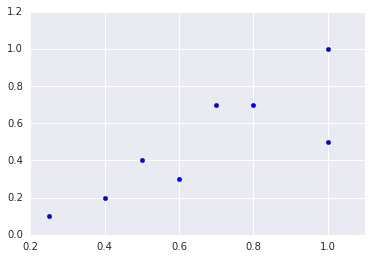

actual t_stat 3.70343707814
p value 0.0085
analytical p-value is 0.0100473771094


In [264]:
%matplotlib inline
import matplotlib.pyplot as plt
from math import sqrt
from scipy.stats import linregress, pearsonr

def get_t_stat_corr(v):
    """ Computes the t-statistic for testing the correlation between
        the two columns of v """
    x = v[:,0]
    y = v[:,1]
    N = v.shape[0]
    R = np.corrcoef(x,y)[0, 1]
    return R / sqrt((1 - R**2) / (N - 2))

# make a sample
data = np.asarray([[1.0, .5],
                   [0.25, .1],
                   [0.5, .4], 
                   [0.6, .3],
                   [.7, .7],
                   [0.8, .7],
                   [.4, .2],
                   [1.0, 1.0]])

plt.scatter(data[:,0], data[:,1])
plt.show()

# compute the t-statistic for our sample
t_stat = get_t_stat_corr(data)
print "actual t_stat", t_stat

# compute the p-value using the analytical approach
_, p_value_analytical = pearsonr(data[:,0], data[:,1])
print "analytical p-value is", p_value_analytical

In much the same way as we did in the previous example, we can estimate the p-value using a simulation approach.  To do so, we will repeatedly simulate the null hypothesis by generating a random matrix with dimensions equal to `data` from a Gaussian distribution with mean 0 and standard deviation 1.  To get the p-value we will compare the magnitude of the t-statistic under the null hypothesis with the t-statistic from our sample.

In [271]:
n_trials = 100000

t_stats = [get_t_stat_corr(np.random.normal(size=data.shape)) for i in range(n_trials)]
print "simulation p value", np.mean(np.abs(t_stats) > t_stat)

simulation p value 0.01


Just as before we can compare the distribution of t-statistics under the null hypothesis with the student's t-distribution.  In this case we will compare it with the student's t-distribution with $n-2$ degrees of freedom.

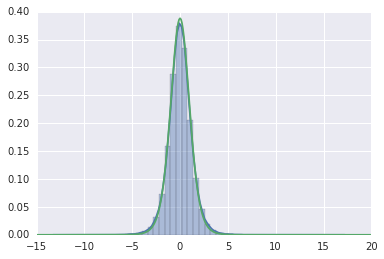

In [274]:
sns.distplot(t_stats)
points = np.arange(plt.xlim()[0], plt.xlim()[1], .1)
plt.plot(points, [scipy.stats.t.pdf(point, len(x) - 2) for point in points])
plt.show()

Finally, we can see that all that simulation was in fact unnecessary.

In [281]:
1 - \
    scipy.stats.t.cdf(t_stat, data.shape[0] - 2) + \
    scipy.stats.t.cdf(-t_stat, data.shape[0] - 2)

0.01004737710936727

### Testing the Difference between Two Means

Now it's your turn.  Use a student's t-test to test the hypothesis that two populations have differing means.  Several forms of the test are given in the [Wikipedia article](https://en.wikipedia.org/wiki/Student's_t-test).  I would recommend using the one that [doesn't assume equal numbers but assumes equal variance](https://en.wikipedia.org/wiki/Student's_t-test#Equal_or_unequal_sample_sizes.2C_equal_variance).  If you want to be ambitious, you can try the one that doesn't assume equal variance.

To make sure you have things down, go through the following steps:
1.  Create two samples.  To make it interesting they should probably have different means.
2.  Compute the t-statistic and p-value using [scipy.stats.ttest_ind](http://docs.scipy.org/doc/scipy-0.16.0/reference/generated/scipy.stats.ttest_ind.html)
3.  Create a function to compute the t-statistic yourself.  Verify that it matches what the test returns.
4.  Use a simulation approach to estimate the p-value.  Make sure it matches the value returned from scipy.stats.
5.  Plot the observed distribution of t-statistics fromt he simulation approach.  On the same plot, show the appropriate t-distribution.  Make sure that these two distributions coincide.
6.  Use the student's t-distribution to calculate the p-value.  Make sure it mathces up with what scipy.stats returned.